In [26]:
from scipy.special import softmax
import pickle
import math
from itertools import cycle
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch 
from itertools import count
from torch import nn, optim
from pydiffmap import diffusion_map as dm
from sklearn.preprocessing import MinMaxScaler
from pydiffmap.visualization import embedding_plot, data_plot
from pydiffmap import diffusion_map as dm
from collections import namedtuple
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
with open('corr.obj', 'rb') as fp:
    cor = pickle.load(fp)
    
with open('means.obj', 'rb') as fp:
    interest_mean = pickle.load(fp)

In [65]:
def diffusion_graph(customers):
    """Creates a fully connected graph markovian matrix via a kernel of all distance pairs. This matrix will be used to 
    model interest diffusion.

    Args:
      customers: All customers with their interest.

    Returns:
      The transion matrix.
    """ 
    neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}
    mydmap = dm.DiffusionMap.from_sklearn(n_evecs=2, k=10, epsilon='bgh', alpha=1.0, neighbor_params=neighbor_params)
    dmap = mydmap.fit_transform(customers)
    transition_matrix = mydmap.kernel_matrix.todense()
    np.fill_diagonal(transition_matrix, 0)
    transition_matrix = transition_matrix / transition_matrix.sum(axis=1)
    transition_matrix =  softmax(transition_matrix, axis=1)
    return transition_matrix

def customer_sampeling(interest_mean, cor, samples):
    """Samples customers according a mean array and covariance matrix.

    Args:
      interest_mean: The mean array of the interest distribution.
      cor: The covariance matrix of the interest distribution.
      samples: The number of customers

    Returns:
      The customers as an array with size (samples, interest_num).
    """ 
    return softmax(np.random.multivariate_normal(interest_mean, cor, samples), axis=1)

def history_initialization(samples, hist_length, int_num):
    """Initializes the customer histories.

    Args:
      hist_length: The number of items in the history of each cutomer used to recommend the next item.
      int_num: The number of interests, here 31.
      samples: The number of customers.

    Returns:
      Returns a randomly initialized intital history.
    """ 
    history = np.zeros(shape = (samples*hist_length, int_num))
    int_idx = np.random.choice(np.arange(0, int_num), (samples*hist_length))
    for i in range(samples*hist_length):
        history[i, int_idx[i]] = 1

    return history.reshape((samples, hist_length, int_num))

def history_iterator(samples, hist_length):
    """Initializes the history update iterators used to allways update the oldest history entry.

    Args:
      hist_length: The number of items in the history of each cutomer used to recommend the next item.
      int_num: The number of interests, here 31.
      samples: The number of customers.

    Returns:
      Returns a list of cyclical lists.
    """ 
    history_index = []
    for i in range(samples):
        lst = np.arange(0, hist_length, 1)
        pool = cycle(lst)
        history_index.append(pool)
        
    return history_index

In [74]:
class Environment():
    def __init__(self, samples, hist_length, interest_mean, int_num, int_decay, trans):
        """
        samples: The number of customers using the recommender.
        hist_length: The number of last pruchases the model uses for the next recommendation. 
        intrest_mean: The mean of the interest distributions.
        int_num: The number of interest categories.
        int_decay: The percentage one interest decreases with each succesive recommendation of that category.
        trans: The percentage chance for a customer to diffuse on the customer interest graph.
        """
        self.customers = customer_sampeling(interest_mean, cor, samples)
        self.history = history_initialization(samples, hist_length,int_num)
        
        self.int_mod = np.zeros(shape = (samples, int_num))
        self.cust_id = np.arange(0, samples, 1)
        self.cust_state = np.arange(0, samples, 1)
        
        self.samples = samples
        self.hist_length = hist_length 
        self.int_num = int_num
        self.int_decay = int_decay
        self.trans = trans
        
        self.transition_matrix =  diffusion_graph(self.customers)
        self.history_index = history_iterator(samples, hist_length)
        
    def state(self):
        """A function that returns a state, in the form of a pruchase history, and a customer id.

        Returns:
          Returns a state and customer id.
        """ 
        choice_id = np.random.choice(self.cust_id)
        return self.history[self.cust_state[choice_id], ::, ::], choice_id
    
    def history_update(self, choice_id):
        """Returns the updated history of a customer.

        Args:
          choice_id: The customer id.

        Returns:
          Returns the updated history.
        """ 
        return self.history[self.cust_state[choice_id], ::, ::]
    
    def int_stc(self, reward, choice_id, action):
        """Models the interest decay after a recomendation and relaxes all not recomended categories back to the base line.

        Args:
          reward: The reward that the mode got for its action.
          choice_id: The customer id.
          action: The action that the model chose in vector form.
        """ 
        action_idx = np.argmax(action)
        if reward == 1:
            self.int_mod[self.cust_state[choice_id], action_idx] -= self.int_decay*self.customers[self.cust_state[choice_id], action_idx]
        
        mask = np.ones(self.int_num, bool)
        mask[action_idx] = False

        self.int_mod[self.cust_state[choice_id], mask] += self.int_decay*self.customers[self.cust_state[choice_id], mask]
        
        for i in range(self.int_num):
            if self.int_mod[self.cust_state[choice_id], i] > 0:
                self.int_mod[self.cust_state[choice_id], i] = 0
            if self.int_mod[self.cust_state[choice_id], i] + self.customers[self.cust_state[choice_id], i] < 0:
                self.int_mod[self.cust_state[choice_id], i] = - self.customers[self.cust_state[choice_id], i]
                
    def int_drift(self, choice_id):
        """One diffusion step of with a chance of trans for the customer corresponding to choice_id.

        Args:
            choice_id: The customer id.
        """ 
        change = np.random.choice([0, 1], p=[1-self.trans, self.trans])
        if change == 1:
            trans_prop = self.transition_matrix[self.cust_state[choice_id], ::]
            trans_prop = np.array(trans_prop)[0]
            self.cust_state[choice_id] = np.random.choice(self.cust_state, p = trans_prop)
        
    def step(self, choice_id, action):
        """Updates the purchasing history if the cutomer buy the item and returns a reward.

        Args:
          choice_id: The customer id.
          action: The action that the model chose in vector form.

        Returns:
          Returns a list of cyclical lists.
        """ 
        self.history[next(self.history_index[self.cust_state[choice_id]]),::] = action
        
        int_action_match = (self.customers[self.cust_state[choice_id], action] + self.int_mod[self.cust_state[choice_id], action])
        
        reward = np.random.choice([0, 1], p = [1-int_action_match, int_action_match])
        if reward == 1:
            self.history[next(self.history_index[self.cust_state[choice_id]]),::] = action
            
        return reward     

In [67]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    """The ReplayMemory saves states, actions, the next state and the reward to be sampled for training.
    """
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """pushes a new pair of state, action, next_state and reward to the buffer.
        """ 
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """samples a batch from the memory.

        Args:
          batch_size: The number of state, action, next_state and reward pairs that are sampled.

        Returns:
          Returns a batch for training.
        """ 
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [68]:
hidden = 100
class DQN(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_input_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features= hidden)
        
        self.bn1 = nn.BatchNorm1d(num_features=hidden)
        self.encoder_hidden_layer1 = nn.Linear(
            in_features= hidden, out_features= hidden)
        
        self.bn2 = nn.BatchNorm1d(num_features=hidden)
        self.encoder_hidden_layer2 = nn.Linear(
            in_features= hidden, out_features= hidden)
        
        self.bn3 = nn.BatchNorm1d(num_features=hidden)
        self.encoder_hidden_layer3 = nn.Linear(
            in_features= hidden, out_features= hidden)
        
        self.bn4 = nn.BatchNorm1d(num_features=hidden)
        self.encoder_output_layer = nn.Linear(
            in_features= hidden, out_features= interesst_num)
        
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.encoder_input_layer(x)
        x = x.view(-1, hidden)
        x = self.bn1(x)
        x = self.act(x)
        
        x = self.bn2(self.encoder_hidden_layer1(x))
        x = self.act(x)
        
        x = self.bn3(self.encoder_hidden_layer2(x))
        x = self.act(x)
        
        x = self.bn4(self.encoder_hidden_layer3(x))
        x = self.act(x)
        
        x = self.encoder_output_layer(x)        
        return x

In [69]:
BATCH_SIZE = 256
GAMMA = 0.5
EPS_START = 0.6
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 100

hist_length = 10
interesst_num = 31
hist_length = 40
samples = 50
int_decay = 0.2
trans = 0.01

In [70]:
env = Environment(samples = samples, hist_length = hist_length, interest_mean = interest_mean, 
                  int_num = 31, int_decay = int_decay, trans = trans)

policy_net = DQN(input_shape = interesst_num*hist_length).to(device)
target_net = DQN(input_shape = interesst_num*hist_length).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=0.001)
memory = ReplayMemory(10000)

In [71]:
steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            policy_net.eval()
            pol = torch.argmax(policy_net(state.view(-1).float())).view(1, 1)
            policy_net.train()
            return pol
    else:
        return torch.tensor([[random.randrange(interesst_num)]], device=device, dtype=torch.long)

In [72]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).view(BATCH_SIZE, interesst_num*hist_length).to(device)
        
    state_batch = torch.cat(batch.state).view(BATCH_SIZE, interesst_num*hist_length).to(device)
    action_batch = torch.stack(batch.action).view(BATCH_SIZE, 1)
    reward_batch = torch.cat(batch.reward).view(BATCH_SIZE)
    
    # Compute Q(s_t, a)
    state_action_values = policy_net(state_batch.float()).gather(1, action_batch).view(BATCH_SIZE)
    
    # Compute V(s_{t+1})
    next_state_values = torch.zeros((BATCH_SIZE), device=device)
    next_state_values = target_net(non_final_next_states.float()).max(1)[0].detach()

    # expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
    # Optimize
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

C:\Users\magnu\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


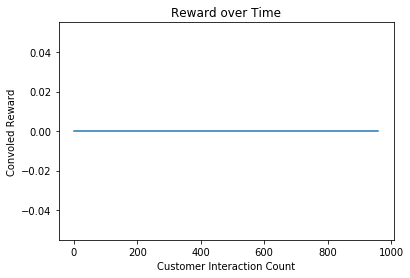

C:\Users\magnu\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


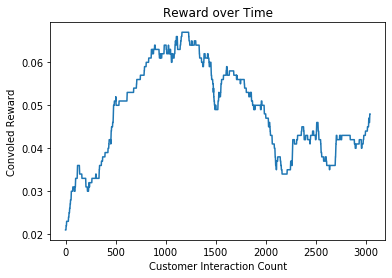

C:\Users\magnu\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


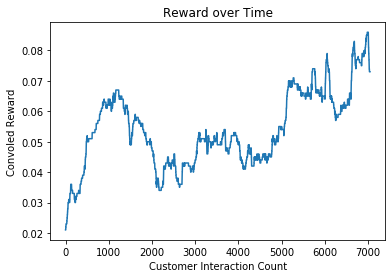

C:\Users\magnu\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


KeyboardInterrupt: 

In [73]:
num_episodes = 10000
hist_loop = 1
rev = np.zeros(shape =(num_episodes*hist_length*hist_loop))
j = 0
for i_episode in range(num_episodes):
    # Initialize environment get one state state
    state, choice_id = env.state()
    reward_total = 0
    for i in range(hist_length*hist_loop):
        # Select and perform an action
        state = torch.tensor(state).to(device)
        action = select_action(state)
        reward = env.step(choice_id, action.cpu().numpy().item())
        reward = torch.tensor([reward], device=device)
        
        next_state = torch.tensor(env.history_update(choice_id))
        env.int_stc(reward, choice_id, action.cpu().numpy().item())
        env.int_drift(choice_id)
        # Store the transition
        memory.push(state, action, next_state, reward.view(1, 1))

        # Move to the next state
        state = next_state

        # One optimization step
        optimize_model()
        rev[j] = reward
        j += 1
        
    if i_episode % 100 == 0:    
        fig, ax = plt.subplots()
        N = 1000
        av = np.convolve(np.array(rev[0:j]), np.ones(N)/N, mode='valid')
        ep = np.arange(0, av.shape[0], 1)
        ax.plot(ep, av)
        
        ax.set(xlabel='Customer Interaction Count', ylabel='Convoled Reward',
               title='Reward over Time')
        plt.show()
        
    # copy DQN to target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())